# Import Useful Libraries

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
%matplotlib inline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


# Helper Functions

In [2]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
    
def calc_extrapolate_point(y,b,m):
    
    x = int((y-b)/m)
    point = (x,y)
    return point

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):

    #define average slope for the detected lines with defined thershould
    t_right_slope = 0.55
    t_left_slope = -0.6
    slope_thershould = 0.2
    
    #define arrays for the filtered lines
    x_right_lines = []
    y_right_lines = []
    x_left_lines = []
    y_left_lines = []
    
    
    y_extrapolate_start = img.shape[0]
    y_extrapolate_end = int(img.shape[0]/2+50)
    
    global gb_start_right,gb_end_right,gb_start_left,gb_end_left

    for line in lines:
        for x1,y1,x2,y2 in line:
            slope =((y2-y1)/(x2-x1))
            if (slope >0 and slope > (t_right_slope-slope_thershould) and slope < (t_right_slope+slope_thershould)):
                x_right_lines.extend((x1,x2))
                y_right_lines.extend((y1,y2))
            elif (slope <0 and slope > (t_left_slope-slope_thershould) and slope < (t_left_slope+slope_thershould)):
                x_left_lines.extend((x1,x2))
                y_left_lines.extend((y1,y2))
    
    if (len(x_right_lines)>0):
        #get coefficient of right lines
        m,b = np.polyfit(x_right_lines,y_right_lines,1)
        gb_start_right = calc_extrapolate_point(y_extrapolate_start,b,m)
        gb_end_right = calc_extrapolate_point(y_extrapolate_end,b,m)
        cv2.line(img, gb_start_right, gb_end_right, color, thickness)

    else:
        cv2.line(img, gb_start_right, gb_end_right, color, thickness)
        
    if (len(x_left_lines)>0):
        #get coefficient of left lines
        m,b = np.polyfit(x_left_lines,y_left_lines,1)
        gb_start_left = calc_extrapolate_point(y_extrapolate_start,b,m)
        gb_end_left = calc_extrapolate_point(y_extrapolate_end,b,m)
        cv2.line(img, gb_start_left, gb_end_left, color, thickness)
    else:
        cv2.line(img, gb_start_left, gb_end_left, color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

# Build a Lane Finding Pipeline

In [3]:
def Lane_Pipeline(image):
    
    # Apply grayscale the image
    gray_image = grayscale(image)
    
    # Define a kernel size to apply Gaussian smoothing
    kernel_size = 5
    smooth_image = gaussian_blur(gray_image,kernel_size)

    # Define parameters to apply Canny Edge Detection.
    low_threshold = 80
    high_threshold = 160
    canny_edges = canny(smooth_image, low_threshold, high_threshold)
    
    # Define a four sided polygon to draw the Region of interest
    X_side = image.shape[1]
    Y_side = image.shape[0]
    
    Bottom_Left = (0, Y_side)
    Upper_Left = ((X_side/2)-30,(Y_side/2)+50)
    Upper_Right = ((X_side/2)+50,(Y_side/2)+50)
    Bottom_Right = (X_side,Y_side)
    
    vertices = np.array([[Bottom_Left, Upper_Left, Upper_Right, Bottom_Right]], dtype=np.int32)
    
    masked_edges = region_of_interest(canny_edges, vertices)
    
    # Define paramters to apply Hough Transform
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 70    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 70 #minimum number of pixels making up a line
    max_line_gap = 50    # maximum gap in pixels between connectable line segments

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    Hough_lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    
    # Draw the lines on the edge image
    Final_image = cv2.addWeighted(image, 0.8, Hough_lines, 1, 0) 
    
    return Final_image

    
    

# Test Images

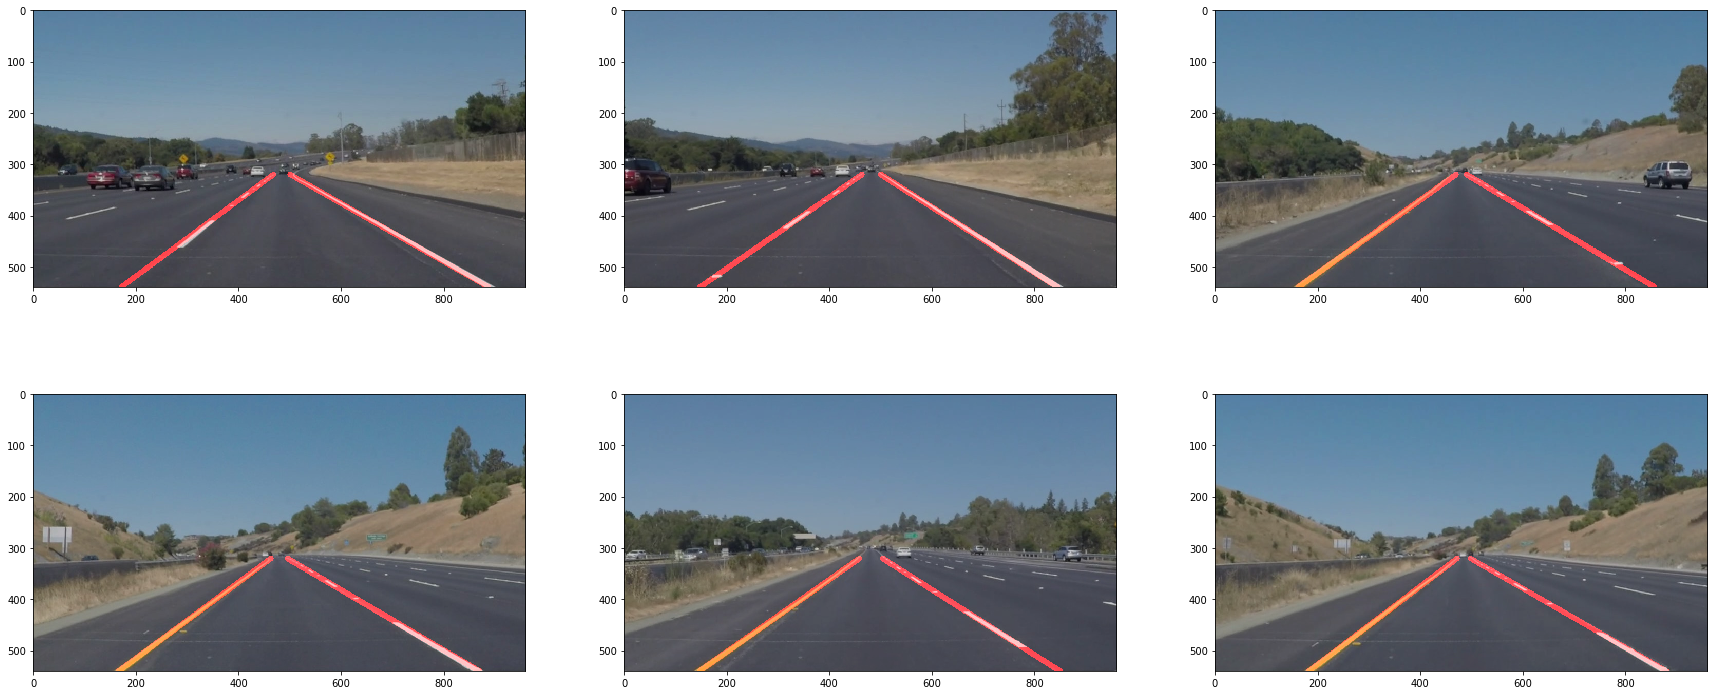

In [4]:
image = os.listdir("test_images/")
columns = 3
plt.figure(figsize=(30,20))
for i,sel_img in enumerate(image):
    selected_image = mpimg.imread('test_images/'+ sel_img)
    Lane_image = Lane_Pipeline(selected_image)
    cv2.imwrite('test_images_output/'+sel_img,Lane_image)
    plt.subplot(len(image) / columns + 1, columns, i + 1)
    plt.imshow(Lane_image,cmap='gray')

# Test Videos

In [5]:
def process_image(image):
    result  = Lane_Pipeline(image)
    return result

# Test on solidWhiteRight Video

In [6]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:04<00:00, 51.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 4.71 s


In [7]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

# Test on solidYellowLeft Video

In [8]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:15<00:00, 44.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 15.6 s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

# Test on Challenge Video

In [10]:
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:10<00:00, 23.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 11.7 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))